This data set consists of 100,000 ratings (1-5) from 943 users on 1682 movies. The time stamps are unix seconds since 1/1/1970 UTC. 

# **Import library and read the data file**

In [2]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

--2020-06-12 06:06:27--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  11.8MB/s    in 0.4s    

2020-06-12 06:06:27 (11.8 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import math
import random

TensorFlow 1.x selected.


# **Dowload the data files**

In [4]:
data = pd.read_csv("ml-100k/u.data", sep='\t',names="userId,movieId,rating,timestamp".split(",")) 
# sort the timestamp ascending
u1_data = data.sort_values(by=['timestamp'])
u1_data

,userId,movieId,rating,timestamp
214,259,255,4,874724710
83965,259,286,4,874724727
43027,259,298,4,874724754
21396,259,185,4,874724781
82655,259,173,4,874724843
...,...,...,...,...
46773,729,689,4,893286638
73008,729,313,3,893286638
46574,729,328,3,893286638
64312,729,748,4,893286638


In [5]:
user_list = data['userId']
user_list = user_list.unique()
test_novelty = pd.DataFrame(user_list, columns = ["userId"])

movie_rated_by_user = data.groupby('movieId')['userId'].count().reset_index(name='userIdCount')
movie_rated_by_user = movie_rated_by_user.set_index('movieId')
movie_rated_by_user

,userIdCount
movieId,
1,452
2,131
3,90
4,209
5,86
...,...
1678,1
1679,1
1680,1


In [6]:
item_column_name = "movieId,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western"
item = pd.read_csv("ml-100k/u.item",sep='|',names=item_column_name.split(","),encoding='latin-1')
col_to_removed = ['movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
clear_item = item.drop(col_to_removed, axis=1).set_index('movieId')

# the number of the kinds of topics in the whole recommendation system.
N = len(clear_item.columns)

# sum up the genre for each movieId
genre_num = clear_item.sum(axis = 1)

# group table by index and creates a dict with lists of clear_item as values
df_dict = dict(list(clear_item.groupby(clear_item.index)))

# Gather all the genres that related to all movies respectively
movieid = []
genre_list = []

for u, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    if len(check) > 0:
      movieid.append(u)
      genre_list.append(check.to_list())

d = {'movieId' : movieid, 'Genres' : genre_list}

# compile in DataFrame
genre_list_by_movieid = pd.DataFrame(d)
genre_list_by_movieid.set_index('movieId', inplace=True)
genre_list_by_movieid

,Genres
movieId,
1,"[Animation, Children, Comedy]"
2,"[Action, Adventure, Thriller]"
3,[Thriller]
4,"[Action, Comedy, Drama]"
5,"[Crime, Drama, Thriller]"
...,...
1678,[Drama]
1679,"[Romance, Thriller]"
1680,"[Drama, Romance]"


# **Preprocess data**

In [0]:
users = u1_data['userId'].values
movies = u1_data['movieId'].values
ratings = u1_data['rating'].values

In [0]:
# movies

In [9]:
# encode the movieId, but in this case is not neccessary since the movieId is from 1 to 1682
# encoded = LabelEncoder().fit_transform(movies)
movies_unique = np.unique(movies)
movies_unique

array([   1,    2,    3, ..., 1680, 1681, 1682])

# **Split data into train test set**

In [0]:
from sklearn.model_selection import train_test_split

train_users, test_users, train_movies, test_movies, train, test = train_test_split(users, movies, u1_data, test_size = 0.25, shuffle = False) #should put suffle? No, as we want it learn by time series

In [11]:
print('train_users: {}' .format(train_users.shape))
print('test_users: {}' .format(test_users.shape))
print('train_movies: {}' .format(train_movies.shape))
print('test_movies: {}' .format(test_movies.shape))
print('train: {}' .format(train.shape))
print('test: {}' .format(test.shape))
print("The total unique user in train set: ", len(train['userId'].unique()))

train_users: (75000,)
test_users: (25000,)
train_movies: (75000,)
test_movies: (25000,)
train: (75000, 4)
test: (25000, 4)
The total unique user in train set:  708


# **Inspect splitted data**

In [12]:
train_users

array([259, 259, 259, ..., 832, 832, 832])

In [13]:
test_users

array([832, 832, 832, ..., 729, 729, 729])

In [14]:
train_movies

array([255, 286, 298, ..., 678, 681, 243])

In [15]:
test_movies

array([322, 748, 288, ..., 328, 748, 272])

In [16]:
train

,userId,movieId,rating,timestamp
214,259,255,4,874724710
83965,259,286,4,874724727
43027,259,298,4,874724754
21396,259,185,4,874724781
82655,259,173,4,874724843
...,...,...,...,...
68659,832,873,2,888259984
58685,832,334,2,888259984
95107,832,678,2,888259984
60891,832,681,2,888259984


In [17]:
print("The total unique user in train set: ", len(train['userId'].unique()))

The total unique user in train set:  708


In [18]:
test

,userId,movieId,rating,timestamp
70773,832,322,3,888259984
93840,832,748,3,888259984
88644,832,288,3,888259984
68968,832,323,3,888259984
60883,832,245,3,888259984
...,...,...,...,...
46773,729,689,4,893286638
73008,729,313,3,893286638
46574,729,328,3,893286638
64312,729,748,4,893286638


In [19]:
# Filter out the rating below 3 as we consider high rated items are those rating equal or above 3
indexNames = test[test['rating'] <= 3 ].index
 
# Delete these row indexes from dataFrame
test.drop(indexNames , inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
test

,userId,movieId,rating,timestamp
59328,832,471,4,888260089
61651,640,354,4,888262331
57538,487,833,4,888262381
70737,454,751,4,888265376
19662,454,487,4,888266565
...,...,...,...,...
74244,729,300,4,893286638
52134,729,333,4,893286638
46773,729,689,4,893286638
64312,729,748,4,893286638


In [21]:
print("The total unique user in test set: ", len(test['userId'].unique()))

The total unique user in test set:  353


In [22]:
print("Minimum rating on test set: {}" .format(min(test['rating'])))
print("Maximum rating on test set: {}" .format(max(test['rating'])))

Minimum rating on test set: 4
Maximum rating on test set: 5


In [23]:
# aggregate all the movieId that have been rated with above 3 by all user
test_precision = test.copy().groupby('userId')['movieId'].agg(actual = lambda x: list(set(x)))
test_precision

,actual
userId,
1,"[32, 256, 171, 270, 111, 209, 242]"
2,"[1, 257, 269, 14, 13, 272, 273, 275, 276, 277,..."
3,"[320, 321, 260, 327, 328, 329, 331, 340, 181, ..."
4,"[288, 258, 354, 324, 357, 260, 359, 327, 329, ..."
7,"[513, 4, 7, 8, 9, 519, 523, 10, 521, 526, 527,..."
...,...
934,"[514, 2, 1018, 4, 13, 529, 25, 550, 554, 50, 5..."
938,"[1, 258, 257, 260, 1028, 7, 273, 275, 151, 25,..."
940,"[354, 316]"


In [24]:
test_data = test.copy().groupby('userId')['movieId'].agg(actual = lambda x: list(set(x)))
test_data

,actual
userId,
1,"[32, 256, 171, 270, 111, 209, 242]"
2,"[1, 257, 269, 14, 13, 272, 273, 275, 276, 277,..."
3,"[320, 321, 260, 327, 328, 329, 331, 340, 181, ..."
4,"[288, 258, 354, 324, 357, 260, 359, 327, 329, ..."
7,"[513, 4, 7, 8, 9, 519, 523, 10, 521, 526, 527,..."
...,...
934,"[514, 2, 1018, 4, 13, 529, 25, 550, 554, 50, 5..."
938,"[1, 258, 257, 260, 1028, 7, 273, 275, 151, 25,..."
940,"[354, 316]"


# **Process the sparsity**

In [25]:
data_pivoted = train.pivot_table(index='userId', columns='movieId', values='rating')
data_pivoted

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1600,1603,1604,1605,1607,1608,1609,1610,1611,1612,1614,1615,1616,1617,1619,1620,1622,1623,1626,1628,1629,1630,1635,1636,1638,1639,1641,1642,1643,1652,1657,1658,1662,1664,1672,1675,1676,1677,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,NaN,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,NaN,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,NaN,4.0,2.0,5.0,3.0,NaN,NaN,NaN,4.0,NaN,3.0,3.0,4.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
number_NaN = data_pivoted.isna().sum()
na_count = (len(data_pivoted)-data_pivoted.count()).sum()

In [27]:
number_value = np.product(data_pivoted.shape)
percentage_of_sparsity = (na_count / number_value) * 100
percentage_of_sparsity

93.36680003820723

In [28]:
maximum = data_pivoted.max()
max_rating = maximum.max()
max_rating

5.0

In [29]:
minimum = data_pivoted.min()
min_rating = minimum.min()
min_rating

1.0

In [30]:
data_pivoted.fillna(0, inplace=True)
data_pivoted

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1600,1603,1604,1605,1607,1608,1609,1610,1611,1612,1614,1615,1616,1617,1619,1620,1622,1623,1626,1628,1629,1630,1635,1636,1638,1639,1641,1642,1643,1652,1657,1658,1662,1664,1672,1675,1676,1677,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,0.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,0.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,0.0,4.0,2.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
number_NaN = data_pivoted.isna().sum()
na_count = (len(data_pivoted)-data_pivoted.count()).sum()
number_value = data_pivoted.shape[0] * data_pivoted.shape[1]
after_filled_percentage_of_sparsity = (na_count / number_value) * 100
after_filled_maximum = data_pivoted.max().max()
after_filled_minimum = data_pivoted.min().min()
print("Sparsity after filled: " ,after_filled_percentage_of_sparsity)
print("Maximum rating: " ,after_filled_maximum )
print("Minimum rating: " ,after_filled_minimum)

Sparsity after filled:  0.0
Maximum rating:  5.0
Minimum rating:  0.0


# **Build the model**

# **Metrics Functions**

In [32]:
genre_num

movieId
1       3
2       3
3       1
4       3
5       3
       ..
1678    1
1679    2
1680    2
1681    1
1682    1
Length: 1682, dtype: int64

In [33]:
genre_list_by_movieid

,Genres
movieId,
1,"[Animation, Children, Comedy]"
2,"[Action, Adventure, Thriller]"
3,[Thriller]
4,"[Action, Comedy, Drama]"
5,"[Crime, Drama, Thriller]"
...,...
1678,[Drama]
1679,"[Romance, Thriller]"
1680,"[Drama, Romance]"


In [0]:
"""
Precision computation
"""

def precision_per_user(user):
  # user set in test set
  U = 10
  # length of recommendation list
  L = 10

  check_a = test_precision.loc[user]
  result = len(np.intersect1d(check_a['actual'],check_a['predictions']))

  precision = (1 / U) * (result/L)

  return precision

"""
Novelty computation
"""

def novelty_per_user(user):

  M = 943
  L = 10
  sum_novelty = 0
  movie_list = test_precision['predictions'].loc[user]
  for u in movie_list:
    rate_number = movie_rated_by_user.loc[u]
    sum_novelty += math.log2(M/rate_number)

  novelty = sum_novelty/(L)
  return novelty

"""
Diversity computation
"""

# this function is to check how many genre (topics) included in the movie item
def check_genre_num(movieid):
  n_genre = genre_num.loc[movieid]
  return n_genre

# this function is to get the list of genre that included in the movieId
def check_genre_list(movieid):
  movie_genres = genre_list_by_movieid['Genres'].loc[movieid]
  return movie_genres

# get the movie list per user and return the total genres for that list, z_Lu
def total_genre_per_list(user_movies_list):
  
  total_num_list = []
  
  for n in user_movies_list:
      genre = check_genre_list(n)
      for g in genre:
        total_num_list.append(g)
  
  return total_num_list, len(total_num_list)

# get the movie list per user and return the unique genres for that list, S_Lu
def get_unique_genre_list_by_user(user_movies_list):

  total_list = []
  
  for h in user_movies_list:
    g = check_genre_list(h)
    for k in g:
      total_list.append(k)
  
  unique_list = list(set(total_list))

  return unique_list, len(unique_list)

def H_lu(lu):
  slu, n_slu = get_unique_genre_list_by_user(lu)
  zlu, n_zlu = total_genre_per_list(lu)
  H_lu = 0
  # need to find how many times that topic j is appear in Z_Lu list
  for j in slu:
    count_appear = zlu.count(j)
    qj = count_appear/len(zlu)
    H_lu += -(qj * math.log10(qj))

  return H_lu

def Div_lu(Lu):
  sl , SLu = get_unique_genre_list_by_user(Lu)
  Nt = N
  hlu = H_lu(Lu)
  Div_lu = SLu / Nt * hlu

  return Div_lu

# get the userId list in prediction result
def diversity_per_user(user):
  sum_part = 0
  movie_list = test_precision['predictions'].loc[user]

  # total number of topics in recommendation list per user
  zlu, n_zlu = total_genre_per_list(movie_list)

  for item in movie_list:
    txi = check_genre_num(item)
    value1 = txi/n_zlu
    value2 = math.log10(value1)
    sum_part += value1*value2

  diversity_lu = -(sum_part) * Div_lu(movie_list)

  return diversity_lu

In [35]:
from collections import deque
import random
import math

tf.reset_default_graph()

LEARNING_RATE = 1e-5
LAYER_SIZE = 256
OUTPUT_SIZE = np.unique(movies).shape[0]
STATE_SIZE = np.unique(users).shape[0]


class Model:
  def __init__(self):
    self.X = tf.placeholder(tf.int32, [None])
    self.Y = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])
    self.memory = deque(maxlen = 1000)
    
    self.gamma = 0.95
    self.epsilon = 0.5
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.999
        
    embeddings = tf.Variable(tf.random_uniform([STATE_SIZE, LAYER_SIZE], -1, 1))
    embedded = tf.nn.embedding_lookup(embeddings, self.X)
    feed_forward = tf.layers.dense(embedded, LAYER_SIZE, activation = tf.nn.tanh)
    self.logits = tf.layers.dense(feed_forward, OUTPUT_SIZE)
    # calculate error distance between `t` Q values with `t + 1` Q values
    self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
    self.optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(
        self.cost
    )
    self.sess = tf.InteractiveSession()
    self.sess.run(tf.global_variables_initializer())
    
  def act(self, state):
    # if random lower than epsilon, make the model explore
    if random.random() <= self.epsilon:
      return np.random.randint(OUTPUT_SIZE, size = (len(state)))
    # else, return actions from the neural network
    return np.argmax(
        self.sess.run(self.logits, feed_dict = {self.X: state}), axis = 1
    )
  
  def replay(self, batch_size):
    mini_batch = random.sample(self.memory, batch_size)
    replay_size = len(mini_batch)
    X = np.empty((replay_size))
    Y = np.empty((replay_size, OUTPUT_SIZE))
    # 0 is `t` state
    # 1 is action, item_nbr
    # 2 is reward
    # 3 is `t + 1` state
    # 4 is terminal
    states = np.array([a[0] for a in mini_batch])
    new_states = np.array([a[3] for a in mini_batch])
    Q = self.sess.run(self.logits, feed_dict = {self.X: states})
    Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
    for i in range(len(mini_batch)):
        state, action, reward, next_state, done = mini_batch[i]
        target = Q[i]
        target[action] = reward
        if not done:
            target[action] += self.gamma * np.amax(Q_new[i])
        X[i] = state
        Y[i] = target
    cost, _ = self.sess.run(
        [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
    )
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay
    return cost
  
model = Model()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


# **Training**

In [0]:
def get_users_predictions(user_id, n):
  p = model.sess.run(model.logits, feed_dict = {model.X: [user_id]})[0]
  p = p.argsort()[-n:][::-1]
  return [movies_unique[i] for i in p]

In [37]:
from tqdm import tqdm
epoch = 1000
batch_size = 256
record = [None] * epoch

for e in range(epoch):
  recs = []

  for user in test_precision.index:
    predictions = get_users_predictions(user, 10)
    recs.append(predictions)

  test_precision['predictions'] = recs
  loss = []
  precision = []
  novelty = []
  diversity = []

  for ul in test_data.index:
    precision.append(precision_per_user(ul))
    p = np.mean(precision)
    if(p > 1):
      r_precision = 5
    else:
      r_precision = 0

    novelty.append(novelty_per_user(ul))
    n = np.mean(novelty)
    if(n < 4):
      r_novelty = 5
    else:
      r_novelty = 0

    diversity.append(diversity_per_user(ul))
    d = np.mean(diversity)
    if(d > 4):
      r_diversity = 5
    else:
      r_diversity = 0

  for i in range(0, len(train_users) - 1, batch_size):
    index = min(i + batch_size, len(train_users) - 1)
    state = train_users[i: index]
    action = model.act(state)
    next_state = train_users[i + 1: index + 1]
    
    for no, a in enumerate(action):
      if a >= data_pivoted.shape[1]:
        r = 0
      else:
        r =  r_precision + r_novelty + r_diversity #+ data_pivoted.loc[train_users[i + no][-1]].iloc[a]
      model.memory.append((state[no], a, r, next_state[no], r  < 1))
    cost = model.replay(min(batch_size, len(model.memory)))
    loss.append(cost)
    avg_lost = np.mean(loss)
    record[e]= avg_lost

  if e % 10 == 0:
    print('\nepoch: %d, average lost: %f, precision: %f, novelty: %f, diversity: %f, r_p: %f, r_n: %f, r_d: %f,' %(e , avg_lost, p, n, d, r_precision, r_novelty, r_diversity))


epoch: 0, average lost: 95.709435, precision: 0.002295, novelty: 5.463395, diversity: 0.380420, r_p: 0.000000, r_n: 0.000000, r_d: 0.000000,

epoch: 10, average lost: 89.478348, precision: 0.002096, novelty: 5.469047, diversity: 0.383341, r_p: 0.000000, r_n: 0.000000, r_d: 0.000000,

epoch: 20, average lost: 68.754654, precision: 0.002068, novelty: 5.471892, diversity: 0.382619, r_p: 0.000000, r_n: 0.000000, r_d: 0.000000,

epoch: 30, average lost: 56.332012, precision: 0.002238, novelty: 5.480102, diversity: 0.381701, r_p: 0.000000, r_n: 0.000000, r_d: 0.000000,

epoch: 40, average lost: 48.032757, precision: 0.002380, novelty: 5.455263, diversity: 0.382072, r_p: 0.000000, r_n: 0.000000, r_d: 0.000000,

epoch: 50, average lost: 41.314518, precision: 0.002238, novelty: 5.430026, diversity: 0.382751, r_p: 0.000000, r_n: 0.000000, r_d: 0.000000,

epoch: 60, average lost: 36.181030, precision: 0.002380, novelty: 5.451728, diversity: 0.384435, r_p: 0.000000, r_n: 0.000000, r_d: 0.000000,


In [0]:
save_data = pd.DataFrame(record)

In [0]:
from google.colab import files
save_data.to_csv('run28_save_data.csv') 
files.download('run28_save_data.csv')

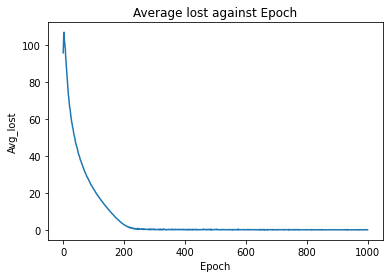

In [40]:
def plot_avg_lost(record):
  plt.title("Average lost against Epoch")
  plt.plot(record)
  plt.xlabel('Epoch')
  plt.ylabel('Avg_lost')
  plt.show()

plot_avg_lost(record)

In [0]:
save_data

,0
0,12.566418
1,11.934852
2,10.908182
3,10.524276
4,9.639491
...,...
95,0.527797
96,0.470593
97,0.420221
98,0.363822


In [41]:
test_precision

,actual,predictions
userId,,
1,"[32, 256, 171, 270, 111, 209, 242]","[966, 958, 177, 1194, 655, 259, 1083, 482, 132..."
2,"[1, 257, 269, 14, 13, 272, 273, 275, 276, 277,...","[1209, 1172, 116, 761, 1477, 1463, 1303, 1360,..."
3,"[320, 321, 260, 327, 328, 329, 331, 340, 181, ...","[471, 449, 13, 287, 947, 450, 48, 942, 1325, 1..."
4,"[288, 258, 354, 324, 357, 260, 359, 327, 329, ...","[1669, 196, 912, 731, 1499, 1025, 1106, 10, 30..."
7,"[513, 4, 7, 8, 9, 519, 523, 10, 521, 526, 527,...","[772, 615, 1498, 898, 669, 1524, 1319, 459, 91..."
...,...,...
934,"[514, 2, 1018, 4, 13, 529, 25, 550, 554, 50, 5...","[207, 256, 1436, 670, 1003, 1357, 484, 1575, 7..."
938,"[1, 258, 257, 260, 1028, 7, 273, 275, 151, 25,...","[636, 1016, 1019, 1389, 912, 579, 1143, 185, 1..."
940,"[354, 316]","[1678, 416, 961, 222, 1199, 1088, 617, 790, 14..."


In [0]:
precision

In [0]:
novelty

In [0]:
diversity

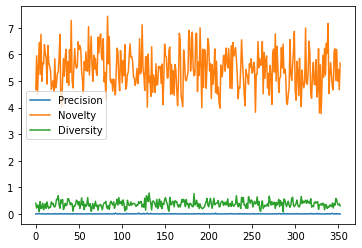

In [48]:
plt.plot(precision, label = "Precision")
plt.plot(novelty, label = "Novelty")
plt.plot(diversity, label = "Diversity")
plt.legend()

# **Extra checking (Optional)**

In [0]:
recs = []

for user in test_precision.index:
  predictions = get_users_predictions(user, 10)
  recs.append(predictions)

test_precision['predictions'] = recs
test_precision

,actual,predictions
userId,,
1,"[115, 100, 101, 103]","[102, 115, 106, 113, 107, 108, 100, 105, 111, ..."
2,"[104, 100, 102]","[102, 107, 100, 103, 101, 109, 110, 108, 104, ..."
3,"[104, 102]","[102, 101, 110, 103, 113, 107, 106, 112, 116, ..."
4,"[105, 106, 103]","[115, 111, 113, 107, 106, 101, 105, 104, 102, ..."
5,"[114, 101, 103]","[115, 102, 107, 111, 113, 105, 104, 101, 100, ..."


In [0]:
test_precision

,actual,predictions
userId,,
1,"[115, 100, 101, 103]","[102, 115, 106, 113, 107, 108, 100, 105, 111, ..."
2,"[104, 100, 102]","[102, 107, 100, 103, 101, 109, 110, 108, 104, ..."
3,"[104, 102]","[102, 101, 110, 103, 113, 107, 106, 112, 116, ..."
4,"[105, 106, 103]","[115, 111, 113, 107, 106, 101, 105, 104, 102, ..."
5,"[114, 101, 103]","[115, 102, 107, 111, 113, 105, 104, 101, 100, ..."


In [0]:
precision = []
novelty = []
diversity = []

for ul in test_data.index:
  precision.append(precision_per_user(ul))
  novelty.append(novelty_per_user(ul))
  diversity.append(diversity_per_user(ul))

p = np.mean(precision)
if(p>0.01):
  r_precision = 10
else:
  r_precision = 0

n = np.mean(novelty)
if(n>0.01):
  r_novelty = 10
else:
  r_novelty = 0

d = np.mean(diversity)
if(d>0.01):
  r_diversity = 10
else:
  r_diversity = 0

In [0]:
print("Precision per user: ", np.mean(precision))
print("Novelty per user: ", np.mean(novelty))
print("Diversity per user: ", np.mean(diversity))
print("r_precision: ", r_precision)
print("r_novelty: ", r_novelty)
print("r_diversity: ", r_diversity)

Precision per user:  0.02
Novelty per user:  7.757929286983641
Diversity per user:  0.4559212955304444
r_precision:  10
r_novelty:  10
r_diversity:  10


In [0]:
precision = []
novelty = []
diversity = []

for ul in test_data.index[:11]:
  precision.append(precision_per_user(ul))
  novelty.append(novelty_per_user(ul))
  diversity.append(diversity_per_user(ul))

In [0]:
print("Precision per user: ", precision)
print("Novelty per user: ", novelty)
print("Diversity per user: ", diversity)

Precision per user:  [0.03, 0.03, 0.010000000000000002, 0.020000000000000004, 0.010000000000000002]
Novelty per user:  [7.720149913231414, 7.7938464726480365, 7.7938464726480365, 7.761653663159299, 7.720149913231415]
Diversity per user:  [0.40250493195376325, 0.46722161954032154, 0.5374148389899738, 0.46996015521440027, 0.4025049319537632]


In [0]:
for ul in test_data.index[:2]:
  print(ul)

1
2


For training 100 epoch: <br>
* Precision per user:  0.012000000000000002
* Novelty per user:  7.715573539421497
* Diversity per user:  0.35202318976936353

For training 1000 epoch: <br>
* Precision per user:  0.008000000000000002
* Novelty per user:  7.7560670988958105
* Diversity per user:  0.38771347088234387

For training 2000 epoch: <br>
* Precision per user:  0.010000000000000002
* Novelty per user:  7.762505660793558
* Diversity per user:  0.3820960971209813

In [0]:
def precision_overall():
  # user set in test set
  U = 10
  # length of recommendation list
  L = 10

  result = test_precision.apply(lambda x: len(np.intersect1d(x['actual'],x['predictions'])), axis = 1)

  # Total up the recommendation item which in the high rated item list
  intersect = sum(result)
  avg_precision = (1 / U) * (intersect/L)

  return avg_precision

In [0]:
precision_overall()

0.06

In [0]:
# full user set in entire test set
U = 353
# length of recommendation list
L = 10

precision = (1 / U) * (intersect/L)
precision

In [0]:
# Test on the first 10 users
# first_10 = result[:10]
# sum_first_10 = sum(first_10)
# sum_first_10

In [0]:
# Collect all genres that related to each movie
genres = []
genre_per_list = []

for user in pred_result.index:
  movies = pred_result['predictions'].loc[user]
  for i in movies:
    genres.append(check_genre_list(i))

# Arrange the list to bind with the random prediction based on userId
genre_per_list = [genres[x:x+10] for x in range(0, len(genres),10)]
genre_per_list

In [0]:
# Add the list into random prediction column
pred_result['genres'] = genre_per_list
pred_result

In [0]:
get_unique_genre_list_by_user(test_slu)

In [0]:
try:
  precision = precision_per_user(1)
  print("Precision per user: ", precision)
except:
  print("====ERROR=======")
  print("User Id may not found")

Precision per user:  0.020000000000000004


In [0]:
try:
  novelty = novelty_per_user(1)
  print("Novelty per user: ", novelty)
except:
  print("====ERROR=======")
  print("User Id may not found")

Novelty per user:  7.687957103742678


In [0]:
try:
  diversity = diversity_per_user(1)
  print("Drecision per user: ", diversity)
except:
  print("====ERROR=======")
  print("User Id may not found")

Drecision per user:  0.3893858430423576
